In [4]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tabulate

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Subset

from datasets import load_from_disk
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_dim = 128          
condition_dim = 10        
gan_epochs = 20            
generation_size = 1000    
batch_size = 32                

full_dataset = load_from_disk('../data/full_dataset_new', keep_in_memory=True)
split_datasets = full_dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = split_datasets['train']
test_dataset = split_datasets['test']

test_x = np.array(test_dataset['embedding'])
test_y = np.array(test_dataset['labels'])

train_x_full = np.array(train_dataset['embedding'])
train_y_full = np.array(train_dataset['labels'])

In [6]:
class Generator(nn.Module):
    def __init__(self, latent_dim=100, condition_dim=10, num_classes=10, start_dim=128, n_layer=3, output_dim=512):
        super(Generator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, condition_dim)
        input_dim = latent_dim + condition_dim
        layers = []

        layers.append(nn.Linear(input_dim, start_dim))
        layers.append(nn.ReLU(inplace=True))
        current_dim = start_dim

        for i in range(1, n_layer):
            next_dim = current_dim * 2
            layers.append(nn.Linear(current_dim, next_dim))
            layers.append(nn.BatchNorm1d(next_dim, momentum=0.8))
            layers.append(nn.ReLU(inplace=True))
            current_dim = next_dim
            
        layers.append(nn.Linear(current_dim, output_dim))
        self.model = nn.Sequential(*layers)

    def forward(self, z, labels):
        label_embedding = self.label_emb(labels)
        x = torch.cat([z, label_embedding], dim=1)
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self, condition_dim=10, num_classes=10, start_dim=128, n_layer=3, input_dim=512):
        super(Discriminator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, condition_dim)
        # input_dim + condition_dim
        input_dim = input_dim + condition_dim
        hidden_dim = start_dim * (2 ** (n_layer - 1))
        layers = []
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(nn.LeakyReLU(0.2, inplace=True))
        current_dim = hidden_dim
        for i in range(1, n_layer):
            next_dim = current_dim // 2
            layers.append(nn.Linear(current_dim, next_dim))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            current_dim = next_dim
        layers.append(nn.Linear(current_dim, 1))
        layers.append(nn.Sigmoid())
        self.model = nn.Sequential(*layers)

    def forward(self, x, labels):
        label_embedding = self.label_emb(labels)
        x = torch.cat([x, label_embedding], dim=1)
        return self.model(x)


class EmbeddingDataset(torch.utils.data.Dataset):
    def __init__(self, hf_dataset):
        self.embeddings = hf_dataset["embedding"]
        self.labels = hf_dataset["labels"]
    def __len__(self):
        return len(self.embeddings)
    def __getitem__(self, idx):
        emb = torch.tensor(self.embeddings[idx], dtype=torch.float)
        label = self.labels[idx]
        return emb, label

train_ds = EmbeddingDataset(train_dataset)

def get_loader(dataset, batch_size=32, shuffle=True):
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

test_ds = EmbeddingDataset(test_dataset)
test_loader = get_loader(test_ds, batch_size=batch_size, shuffle=False)  


[Real Data Only] Training size: 20
KNN Accuracy (Real Data) for size 20: 0.8460
Training Conditional GAN on the same subset...
[GAN Epoch 1/20] D loss: 0.6958, G loss: 0.7153
[GAN Epoch 2/20] D loss: 0.6410, G loss: 0.7043
[GAN Epoch 3/20] D loss: 0.5968, G loss: 0.6965
[GAN Epoch 4/20] D loss: 0.5568, G loss: 0.6850
[GAN Epoch 5/20] D loss: 0.5214, G loss: 0.6682
[GAN Epoch 6/20] D loss: 0.4940, G loss: 0.6478
[GAN Epoch 7/20] D loss: 0.4746, G loss: 0.6340
[GAN Epoch 8/20] D loss: 0.4552, G loss: 0.6452
[GAN Epoch 9/20] D loss: 0.4315, G loss: 0.6913
[GAN Epoch 10/20] D loss: 0.4073, G loss: 0.7741
[GAN Epoch 11/20] D loss: 0.3956, G loss: 0.8471
[GAN Epoch 12/20] D loss: 0.4031, G loss: 0.8472
[GAN Epoch 13/20] D loss: 0.4322, G loss: 0.7889
[GAN Epoch 14/20] D loss: 0.4621, G loss: 0.7885
[GAN Epoch 15/20] D loss: 0.4727, G loss: 0.7533
[GAN Epoch 16/20] D loss: 0.4413, G loss: 0.8090
[GAN Epoch 17/20] D loss: 0.3835, G loss: 0.9087
[GAN Epoch 18/20] D loss: 0.3107, G loss: 1.0703

/tmp/ipykernel_9645/4037647124.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emb = torch.tensor(self.embeddings[idx], dtype=torch.float)
/tmp/ipykernel_9645/470010640.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long).to(device)
/tmp/ipykernel_9645/4037647124.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emb = torch.tensor(self.embeddings[idx], dtype=torch.float)
/tmp/ipykernel_9645/470010640.py:50: UserWarning: To copy construct from a tensor, it is recommended to use source

[GAN Epoch 1/20] D loss: 0.6667, G loss: 0.7208
[GAN Epoch 2/20] D loss: 0.5798, G loss: 0.6850
[GAN Epoch 3/20] D loss: 0.5182, G loss: 0.6374
[GAN Epoch 4/20] D loss: 0.4749, G loss: 0.6222
[GAN Epoch 5/20] D loss: 0.4219, G loss: 0.7363
[GAN Epoch 6/20] D loss: 0.3983, G loss: 0.8669
[GAN Epoch 7/20] D loss: 0.4789, G loss: 0.8082
[GAN Epoch 8/20] D loss: 0.5359, G loss: 0.7001
[GAN Epoch 9/20] D loss: 0.4165, G loss: 0.8847
[GAN Epoch 10/20] D loss: 0.2739, G loss: 1.1701
[GAN Epoch 11/20] D loss: 0.2284, G loss: 1.3017
[GAN Epoch 12/20] D loss: 0.2303, G loss: 1.3000
[GAN Epoch 13/20] D loss: 0.1977, G loss: 1.4322
[GAN Epoch 14/20] D loss: 0.1638, G loss: 1.6360
[GAN Epoch 15/20] D loss: 0.1770, G loss: 1.7604
[GAN Epoch 16/20] D loss: 0.1845, G loss: 2.1559
[GAN Epoch 17/20] D loss: 0.1595, G loss: 2.1879
[GAN Epoch 18/20] D loss: 0.2183, G loss: 1.8171
[GAN Epoch 19/20] D loss: 0.2777, G loss: 2.4564
[GAN Epoch 20/20] D loss: 0.0789, G loss: 3.3843
KNN Accuracy (After Concatena

/tmp/ipykernel_9645/4037647124.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emb = torch.tensor(self.embeddings[idx], dtype=torch.float)
/tmp/ipykernel_9645/470010640.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long).to(device)


[GAN Epoch 10/20] D loss: 0.1883, G loss: 2.2181
[GAN Epoch 11/20] D loss: 0.1321, G loss: 2.0991
[GAN Epoch 12/20] D loss: 0.0910, G loss: 2.9853
[GAN Epoch 13/20] D loss: 0.1033, G loss: 3.2279
[GAN Epoch 14/20] D loss: 0.0615, G loss: 3.8103
[GAN Epoch 15/20] D loss: 0.0623, G loss: 2.9354
[GAN Epoch 16/20] D loss: 0.0589, G loss: 3.2312
[GAN Epoch 17/20] D loss: 0.0995, G loss: 2.6633
[GAN Epoch 18/20] D loss: 0.6504, G loss: 7.5355
[GAN Epoch 19/20] D loss: 0.3047, G loss: 3.7033
[GAN Epoch 20/20] D loss: 0.3528, G loss: 3.0305
KNN Accuracy (After Concatenation) for size 100: 0.8918

[Real Data Only] Training size: 200
KNN Accuracy (Real Data) for size 200: 0.8557
Training Conditional GAN on the same subset...
[GAN Epoch 1/20] D loss: 0.5802, G loss: 0.6609
[GAN Epoch 2/20] D loss: 0.4505, G loss: 0.7564


/tmp/ipykernel_9645/4037647124.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emb = torch.tensor(self.embeddings[idx], dtype=torch.float)
/tmp/ipykernel_9645/470010640.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long).to(device)


[GAN Epoch 3/20] D loss: 0.3619, G loss: 0.9922
[GAN Epoch 4/20] D loss: 0.2330, G loss: 1.3981
[GAN Epoch 5/20] D loss: 0.2370, G loss: 1.8062
[GAN Epoch 6/20] D loss: 0.2457, G loss: 2.0967
[GAN Epoch 7/20] D loss: 0.1270, G loss: 2.8622
[GAN Epoch 8/20] D loss: 0.0830, G loss: 2.6653
[GAN Epoch 9/20] D loss: 0.0891, G loss: 3.0451
[GAN Epoch 10/20] D loss: 0.1348, G loss: 2.9219
[GAN Epoch 11/20] D loss: 0.4763, G loss: 3.3821
[GAN Epoch 12/20] D loss: 0.6805, G loss: 1.9871
[GAN Epoch 13/20] D loss: 0.3310, G loss: 1.6532
[GAN Epoch 14/20] D loss: 0.2359, G loss: 1.9624
[GAN Epoch 15/20] D loss: 0.2712, G loss: 3.2794
[GAN Epoch 16/20] D loss: 0.1863, G loss: 2.3298
[GAN Epoch 17/20] D loss: 0.1689, G loss: 2.2255
[GAN Epoch 18/20] D loss: 0.1901, G loss: 2.8025
[GAN Epoch 19/20] D loss: 0.2160, G loss: 2.7244
[GAN Epoch 20/20] D loss: 0.3362, G loss: 3.3395
KNN Accuracy (After Concatenation) for size 200: 0.8928

[Real Data Only] Training size: 1000
KNN Accuracy (Real Data) for si

/tmp/ipykernel_9645/4037647124.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emb = torch.tensor(self.embeddings[idx], dtype=torch.float)
/tmp/ipykernel_9645/470010640.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long).to(device)


[GAN Epoch 1/20] D loss: 0.3766, G loss: 1.0508
[GAN Epoch 2/20] D loss: 0.1408, G loss: 2.8237
[GAN Epoch 3/20] D loss: 0.3798, G loss: 2.4204
[GAN Epoch 4/20] D loss: 0.2411, G loss: 2.8196
[GAN Epoch 5/20] D loss: 0.2701, G loss: 3.1504
[GAN Epoch 6/20] D loss: 0.3395, G loss: 2.7181
[GAN Epoch 7/20] D loss: 0.3107, G loss: 2.4834
[GAN Epoch 8/20] D loss: 0.3180, G loss: 2.7206
[GAN Epoch 9/20] D loss: 0.3163, G loss: 2.8740
[GAN Epoch 10/20] D loss: 0.3979, G loss: 2.3481
[GAN Epoch 11/20] D loss: 0.3891, G loss: 2.4393
[GAN Epoch 12/20] D loss: 0.4138, G loss: 2.4548
[GAN Epoch 13/20] D loss: 0.4118, G loss: 2.0258
[GAN Epoch 14/20] D loss: 0.4075, G loss: 2.1698
[GAN Epoch 15/20] D loss: 0.4023, G loss: 2.3248
[GAN Epoch 16/20] D loss: 0.3673, G loss: 2.2124
[GAN Epoch 17/20] D loss: 0.4009, G loss: 2.2373
[GAN Epoch 18/20] D loss: 0.3810, G loss: 2.2150
[GAN Epoch 19/20] D loss: 0.4069, G loss: 2.3449
[GAN Epoch 20/20] D loss: 0.3975, G loss: 2.0374
KNN Accuracy (After Concatena

/tmp/ipykernel_9645/4037647124.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emb = torch.tensor(self.embeddings[idx], dtype=torch.float)
/tmp/ipykernel_9645/470010640.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long).to(device)


[GAN Epoch 1/20] D loss: 0.3082, G loss: 2.4527
[GAN Epoch 2/20] D loss: 0.4470, G loss: 2.0159
[GAN Epoch 3/20] D loss: 0.4206, G loss: 1.9518
[GAN Epoch 4/20] D loss: 0.4296, G loss: 1.7462
[GAN Epoch 5/20] D loss: 0.4580, G loss: 1.6689
[GAN Epoch 6/20] D loss: 0.4873, G loss: 1.5085
[GAN Epoch 7/20] D loss: 0.4977, G loss: 1.4194
[GAN Epoch 8/20] D loss: 0.5340, G loss: 1.2648
[GAN Epoch 9/20] D loss: 0.5365, G loss: 1.2262
[GAN Epoch 10/20] D loss: 0.5575, G loss: 1.1283
[GAN Epoch 11/20] D loss: 0.5813, G loss: 1.1055
[GAN Epoch 12/20] D loss: 0.5785, G loss: 1.0839
[GAN Epoch 13/20] D loss: 0.5821, G loss: 1.0498
[GAN Epoch 14/20] D loss: 0.5759, G loss: 1.0798
[GAN Epoch 15/20] D loss: 0.5749, G loss: 1.0718
[GAN Epoch 16/20] D loss: 0.5752, G loss: 1.0829
[GAN Epoch 17/20] D loss: 0.5789, G loss: 1.0809
[GAN Epoch 18/20] D loss: 0.5771, G loss: 1.0871
[GAN Epoch 19/20] D loss: 0.5732, G loss: 1.0882


findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.


[GAN Epoch 20/20] D loss: 0.5815, G loss: 1.0701
KNN Accuracy (After Concatenation) for size 7872: 0.9040

Accuracy Summary:
   Train Samples  Real Only Accuracy  After Concatenation Accuracy
0             20            0.846037                      0.884654
1             50            0.859756                      0.894309
2            100            0.842480                      0.891768
3            200            0.855691                      0.892785
4           1000            0.881606                      0.903963
5           7872            0.885671                      0.903963
╒═════════════════╤══════════════════════╤════════════════════════════════╕
│   Train Samples │   Real Only Accuracy │   After Concatenation Accuracy │
╞═════════════════╪══════════════════════╪════════════════════════════════╡
│              20 │             0.846037 │                       0.884654 │
├─────────────────┼──────────────────────┼────────────────────────────────┤
│              50 │       

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.


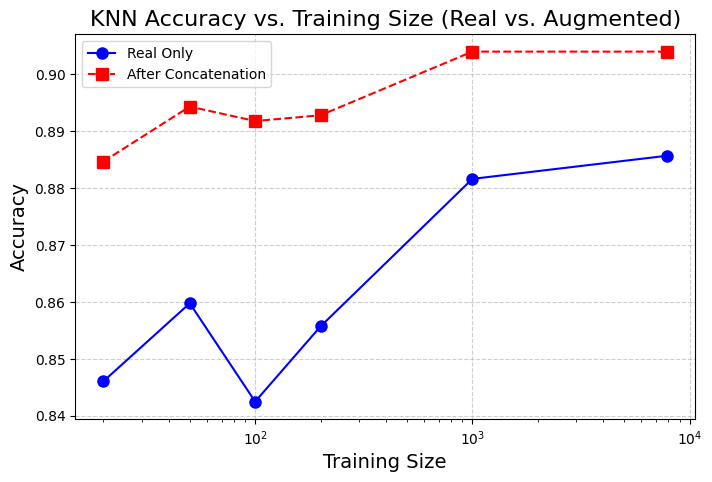

In [7]:

sample_sizes = [20, 50, 100, 200, 1000, len(train_ds)]
knn_accuracy_before = {}
knn_accuracy_after = {}

for size in sample_sizes:
    print(f"\n[Real Data Only] Training size: {size}")
    X_train = train_x_full[:size]
    y_train = train_y_full[:size]

    from sklearn.neighbors import KNeighborsClassifier
    knn_real = KNeighborsClassifier(n_neighbors=1, n_jobs=-1)
    knn_real.fit(X_train, y_train)
    pred_before = knn_real.predict(test_x)
    acc_before = accuracy_score(test_y, pred_before)
    print(f"KNN Accuracy (Real Data) for size {size}: {acc_before:.4f}")
    knn_accuracy_before[size] = acc_before

    print("Training Conditional GAN on the same subset...")
    train_subset = Subset(train_ds, range(size))
    gan_loader = get_loader(train_subset, batch_size=batch_size, shuffle=True)

    input_dim = X_train.shape[1]  
    unique_labels = np.unique(train_y_full)
    num_classes_gan = len(unique_labels)

    generator = Generator(
        latent_dim=latent_dim,
        condition_dim=condition_dim,
        num_classes=num_classes_gan,
        start_dim=latent_dim * 2,
        n_layer=3,
        output_dim=input_dim
    ).to(device)
    discriminator = Discriminator(
        condition_dim=condition_dim,
        num_classes=num_classes_gan,
        start_dim=256,
        n_layer=3,
        input_dim=input_dim
    ).to(device)

    adversarial_loss = nn.BCELoss().to(device)
    optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

    for epoch in range(gan_epochs):
        d_loss_epoch, g_loss_epoch = 0.0, 0.0
        for embeddings, labels in gan_loader:
            embeddings = embeddings.to(device)
            labels = torch.tensor(labels, dtype=torch.long).to(device)
            b_size = embeddings.size(0)

            valid = torch.ones(b_size, 1, device=device)
            fake = torch.zeros(b_size, 1, device=device)

            # Train Generator
            optimizer_G.zero_grad()
            z = torch.randn(b_size, latent_dim, device=device)
            gen_data = generator(z, labels)
            g_loss = adversarial_loss(discriminator(gen_data, labels), valid)
            g_loss.backward()
            optimizer_G.step()

            # Train Discriminator
            optimizer_D.zero_grad()
            real_loss = adversarial_loss(discriminator(embeddings, labels), valid)
            fake_loss = adversarial_loss(discriminator(gen_data.detach(), labels), fake)
            d_loss = (real_loss + fake_loss) / 2
            d_loss.backward()
            optimizer_D.step()

            d_loss_epoch += d_loss.item()
            g_loss_epoch += g_loss.item()

        print(f"[GAN Epoch {epoch+1}/{gan_epochs}] D loss: {d_loss_epoch/len(gan_loader):.4f}, G loss: {g_loss_epoch/len(gan_loader):.4f}")


    synthetic_data_list = []
    synthetic_labels_list = []
    for lab in unique_labels:
        lab_tensor = torch.full((generation_size,), lab, dtype=torch.long, device=device)
        z = torch.randn(generation_size, latent_dim, device=device)
        synth = generator(z, lab_tensor).cpu().detach().numpy()
        synthetic_data_list.append(synth)
        synthetic_labels_list.append(np.full((generation_size,), lab))

    synthetic_x = np.concatenate(synthetic_data_list, axis=0)
    synthetic_y = np.concatenate(synthetic_labels_list, axis=0)

    # (C1) 將真實資料與合成資料合併
    train_combined_x = np.concatenate([X_train, synthetic_x], axis=0)
    train_combined_y = np.concatenate([y_train, synthetic_y], axis=0)

    # (C2) 用 KNN 訓練 (After Concatenation)
    knn_aug = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
    knn_aug.fit(train_combined_x, train_combined_y)
    pred_after = knn_aug.predict(test_x)
    acc_after = accuracy_score(test_y, pred_after)
    print(f"KNN Accuracy (After Concatenation) for size {size}: {acc_after:.4f}")
    knn_accuracy_after[size] = acc_after


summary_df = pd.DataFrame(
    [[s, knn_accuracy_before[s], knn_accuracy_after[s]] for s in sample_sizes],
    columns=["Train Samples", "Real Only Accuracy", "After Concatenation Accuracy"]
)
print("\nAccuracy Summary:")
print(summary_df)
print(tabulate.tabulate(summary_df.values, headers=summary_df.columns, tablefmt="fancy_grid"))

plt.figure(figsize=(8, 5))
plt.plot(sample_sizes, [knn_accuracy_before[s] for s in sample_sizes], marker='o', linestyle='-', color='b', markersize=8, label="Real Only")
plt.plot(sample_sizes, [knn_accuracy_after[s] for s in sample_sizes], marker='s', linestyle='--', color='r', markersize=8, label="After Concatenation")
plt.xlabel("Training Size", fontsize=14, fontfamily="Times New Roman")
plt.ylabel("Accuracy", fontsize=14, fontfamily="Times New Roman")
plt.title("KNN Accuracy vs. Training Size (Real vs. Augmented)", fontsize=16, fontfamily="Times New Roman")
plt.xscale("log")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.show()